## Introduction

Experimental results are mostly not present in the (summarized) way as they are reported in publications in the form of tables or visualizations.
Even if data is already available in a summarized format, it is important to keep the raw results in case you want to present results differently without having to re-run entire experiments.
This notebook gives a few suggestions on how to use *pandas* to summarize data to export it diretly to latex tables or to prepare it for visualizations (e.g. with *seaborn*).
## Raw Data
Ideally prepare your data (model output, raw experimental results) in a format that can easily transformed into a DataFrame.  
Pandas has a variety of ways to import data, but we won't go through all methods and variants here (https://pandas.pydata.org/docs/reference/io.html).  
Just keep in mind, anything that is somehow in a table format (some rows an columns) is in principle very simple to process.

In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set()

# example data
jsonl_string ="""
{"sample_id": 0, "group_id": "A", "variable_1": 0.5, "variable_2": 1.0, "variable_3": ["X", "Y", "Z"]}
{"sample_id": 1, "group_id": "A", "variable_1": 1.5, "variable_2": 1.0, "variable_3": ["X", "Y"]}
{"sample_id": 1, "group_id": "B", "variable_1": 2.5, "variable_2": 1.0, "variable_3": []}
{"sample_id": 2, "group_id": "A", "variable_1": 3.5, "variable_2": 1.0, "variable_3": ["X", "Y", "Z"]}
{"sample_id": 2, "group_id": "B", "variable_1": 3.5, "variable_2": 1.0, "variable_3": ["X"]}
"""
# jsonlines (.jsonl) one JSON object per row, good to store nested data and allows to read only a subset
df = pd.read_json(jsonl_string, lines=True, orient="records") 
df

,sample_id,group_id,variable_1,variable_2,variable_3
0,0,A,0.5,1,"[X, Y, Z]"
1,1,A,1.5,1,"[X, Y]"
2,1,B,2.5,1,[]
3,2,A,3.5,1,"[X, Y, Z]"
4,2,B,3.5,1,[X]


### Preferred DataFrame formats
Initially one row usually represents one sample (of a dataset) but the data types of one sample might not be atomic (e.g. a list of values instead of a single string or number), i.e., nested data. 
Note, that sometimes it might by practicable to process this columns as they are, for instance by writing a custom function that proceses one sample and then to use DataFrame["column"].apply(lambda col: foo(col)).

However, to group, filter, or aggregate based on nested content can be painful, especially if several variables/columns are involved. For this reason, it is often helpful to transform the DataFrame into the so-called "long format". A DataFrame in "long format" if each variable is a column and each observation a row. 

In our example, each value in column *variable_3* of a single row, is an observation.

Pandas is shipped with a couple of useful methods to transform the structure, i.e., by transforming individual, rows, columns, or cells.
Further information: 
- https://seaborn.pydata.org/tutorial/data_structure.html
- https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html

In [32]:
df_long = df.explode("variable_3") 
df_long

,sample_id,group_id,variable_1,variable_2,variable_3
0,0,A,0.5,1,X
0,0,A,0.5,1,Y
0,0,A,0.5,1,Z
1,1,A,1.5,1,X
1,1,A,1.5,1,Y
2,1,B,2.5,1,NaN
3,2,A,3.5,1,X
3,2,A,3.5,1,Y
3,2,A,3.5,1,Z
4,2,B,3.5,1,X


## GroupBy and Aggregate 
One powerful combination to aggregate raw output is the combination of [groupby]() and [agg]().

Example: Count the number of samples (*sample_id*) + calculate the *mean* and *std* for *variable_1* for each *group_id* and each possible value of *variable_3*

In [33]:
df_long.groupby(["group_id", "variable_3"]).agg({"variable_1": [len, np.mean, np.std]})

variable_1                    
                           len      mean       std
group_id variable_3                               
A        X                 3.0  1.833333  1.527525
         Y                 3.0  1.833333  1.527525
         Z                 2.0  2.000000  2.121320
B        X                 1.0  3.500000       NaN

Other methods for filtering, e.g., with `df.loc[~df.COLUMN.isin(List)]` are not covered here.

## Prepare Output for *Latex* Tables:
For non trivial tables (e.g. some multi-row and multi-column indices) it might be a good idea to create the table skeleton manually (or to modify the output initially) and to format the DataFrame that you can copy-paste only the rows.
In this case we do not have to take into consideration the renaming or resetting of column names which can be painful.
In general, [to_latex](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_latex.html) converts a DataFrames to *tex* with many attributes for formatting.

A missing function might be the combination of (two) columns, e.g. if *mean* and *std* should cover one column. One solution would be to edit the DataFrame so that the desired format is available beforehand.
For our example:

In [34]:
# assuming that df or df_long is the raw output and stored separately, we prepare a new DataFrame only to create a table in latex:
df_tex = df_long.groupby(["group_id", "variable_3"]).agg({"variable_1": [len, np.mean, np.std]})
# reset first column index due to unnecessary information and increasing complexity 
df_tex = df_tex.reset_index(drop=False, col_level=1).reset_index(drop=True)
df_tex.columns = [l[1] for l in df_tex.columns]
df_tex

,group_id,variable_3,len,mean,std
0,A,X,3.0,1.833333,1.527525
1,A,Y,3.0,1.833333,1.527525
2,A,Z,2.0,2.000000,2.121320
3,B,X,1.0,3.500000,NaN


In [35]:
# combine and format mean and std column of variable_1
df_tex["variable_1"] = df_tex["mean"].map("{:,.2f}".format) + " (" + df_tex["std"].map("{:,.2f}".format) + ")"
df_tex = df_tex.drop(["mean", "std"], axis=1)
df_tex["len"] = pd.to_numeric(df_tex["len"], downcast="integer") # note: in case of Nones/NaNs, you cannot convert to integer automaticlly
df_tex

,group_id,variable_3,len,variable_1
0,A,X,3,1.83 (1.53)
1,A,Y,3,1.83 (1.53)
2,A,Z,2,2.00 (2.12)
3,B,X,1,3.50 (nan)


In [36]:
# generate table
s = df_tex.to_latex(buf=None, index=False, na_rep=" ", float_format="{:0.2f}".format, multirow=True)
print(s)

\begin{tabular}{llrl}
\toprule
group\_id & variable\_3 &  len &   variable\_1 \\
\midrule
       A &          X &    3 &  1.83 (1.53) \\
       A &          Y &    3 &  1.83 (1.53) \\
       A &          Z &    2 &  2.00 (2.12) \\
       B &          X &    1 &   3.50 (nan) \\
\bottomrule
\end{tabular}



### Note on Encoded and Additional Information (e.g., class indices)
Sometimes additional information are needed to report that are not stored in the raw output -- which is often also not desired -- for instance, attributes accociated with a class label.
One suggestion is to join such information via other DataFrames, which only contains additional information (e.g. class index to label mapping), but is not actually necessary for quantitative evaluation.
Recall: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html

### Note on Distrubuted Result Files
Sometimes, there are several result files, which must first be collected. For instance, files from multiple runs of an experiment or partial results e.g. from several components required for evaluation.
In this case, each file can be converted to a DataFrame where an additional column indicates the fraction (e.g. run number derived from the filename). In the end, functions like [stack](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.stack.html) or [concat](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) collect all indivudal DataFrames into one major one, which can be processed as known.

## Visualization with Seaborn
Seaborn also prefers DataFrames in the "long format" (https://seaborn.pydata.org/tutorial/data_structure.html)
### General hints for publications-quality figures:
- Save as vector graphic (.svg, .pdf, .eps)
- Rename DataFrame's columns according to your paper's notation (as last step): math mode for variables can be used.
- If possible use latex font (requires a locally installed font or is available by a full latex installation)
Further information: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

In [37]:
df = sns.load_dataset("penguins")
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


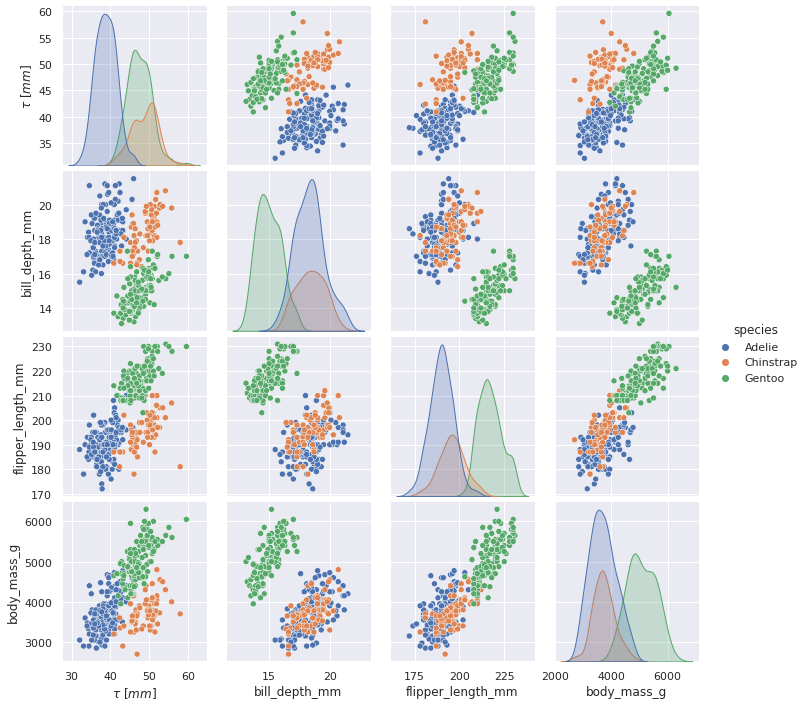

In [38]:
df = df.rename(columns={"bill_length_mm": "$\\tau$ [$mm$]"})
g = sns.pairplot(df, hue="species")